In [1]:
%matplotlib inline


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from astropy.stats import BoxLeastSquares


In [3]:
target = 'l 98-59'
tpf_all = lightkurve.search_targetpixelfile(target).download_all()

In [1]:
tpf_all

NameError: name 'tpf_all' is not defined

In [6]:
tpf1, tpf2, tpf3 = tpf_all[0:3]

In [7]:
texp = tpf1.hdu[1].header['FRAMETIM'] * tpf1.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (tpf1.time.min() + tpf3.time.max())

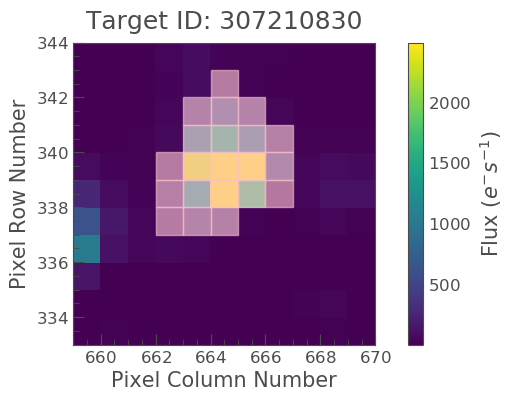

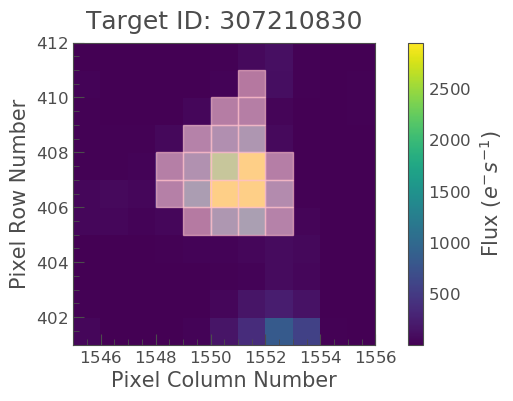

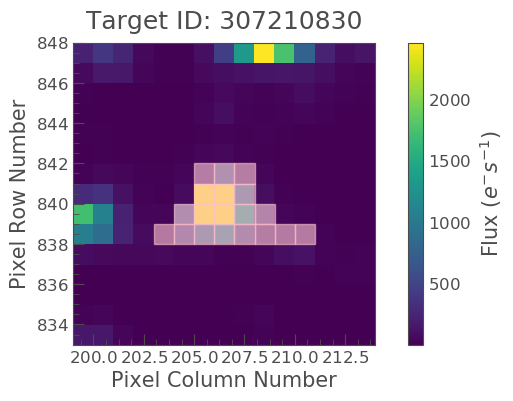

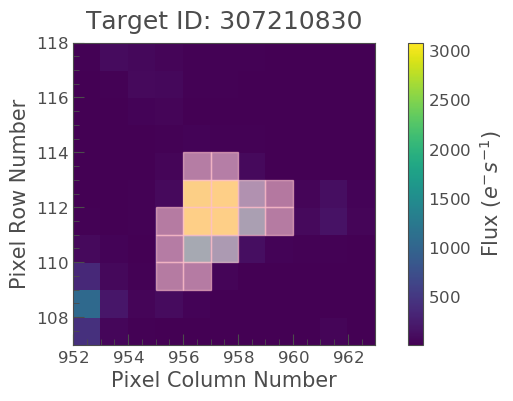

In [8]:
for tpf in tpf_all:

    pix_mask = tpf.create_threshold_mask(threshold=3)
    tpf.plot(aperture_mask=pix_mask, frame=1000)

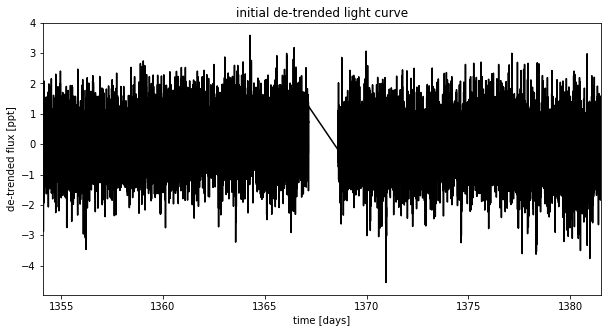

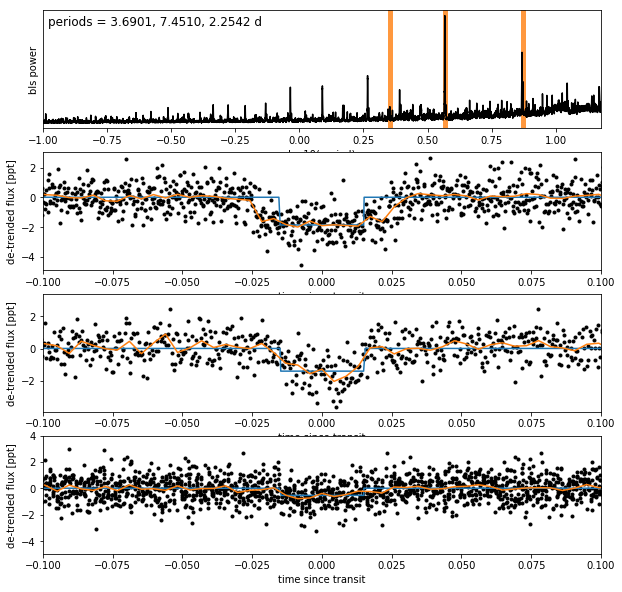

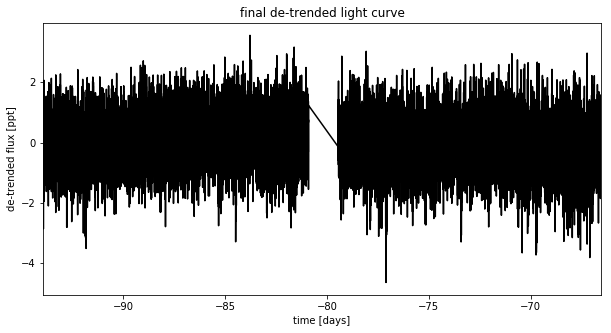

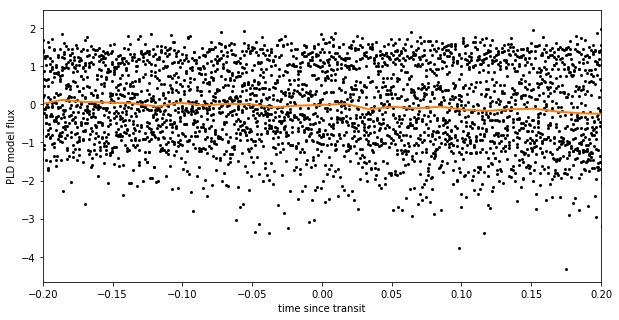

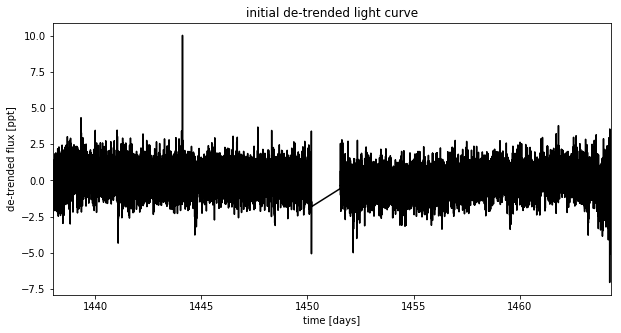

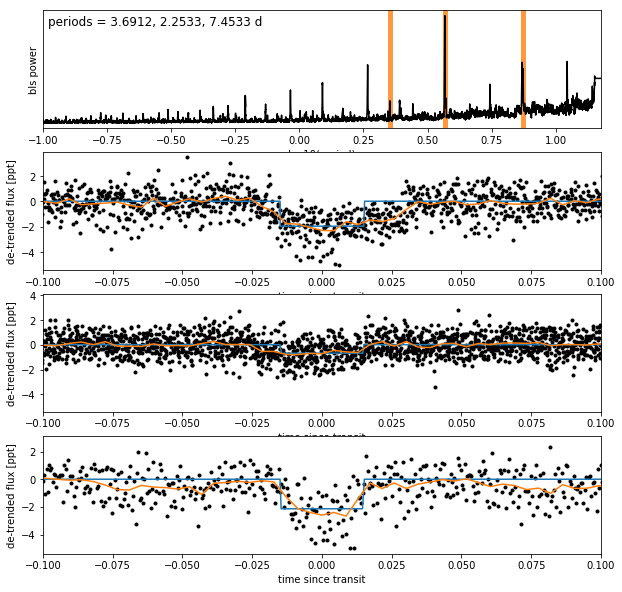

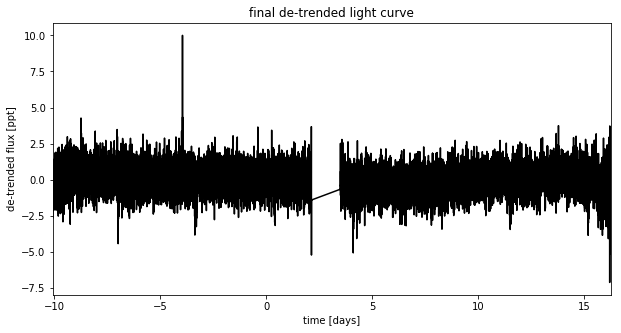

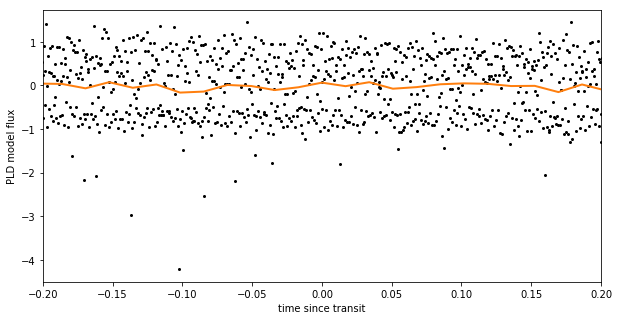

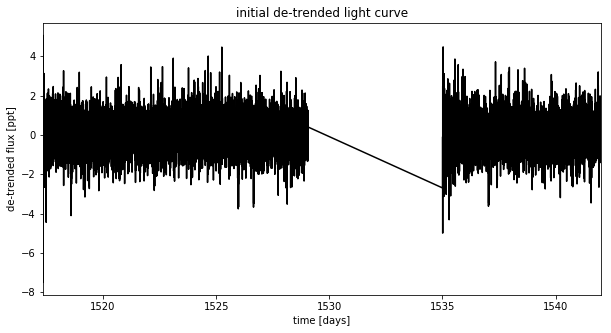

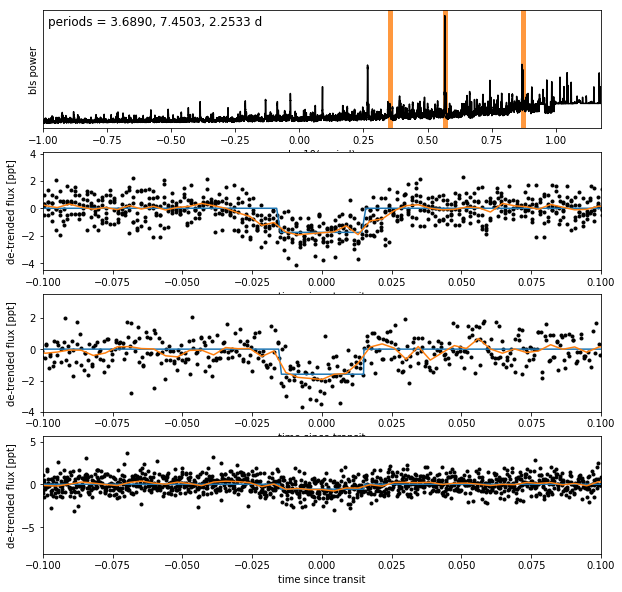

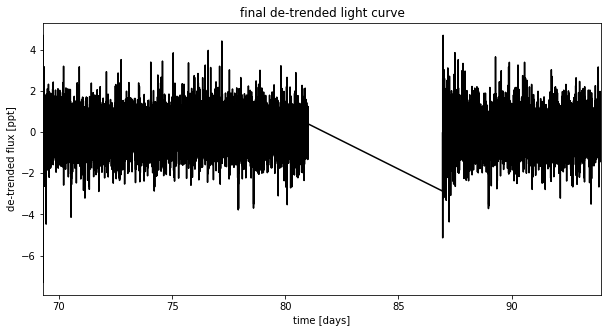

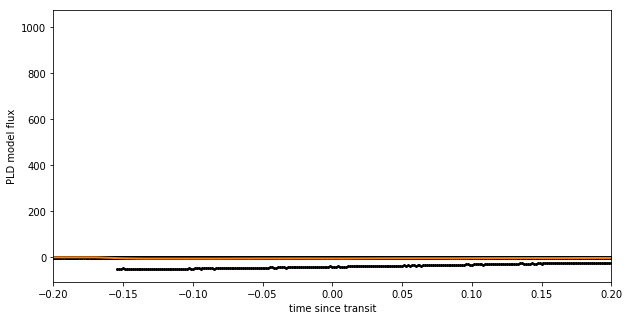

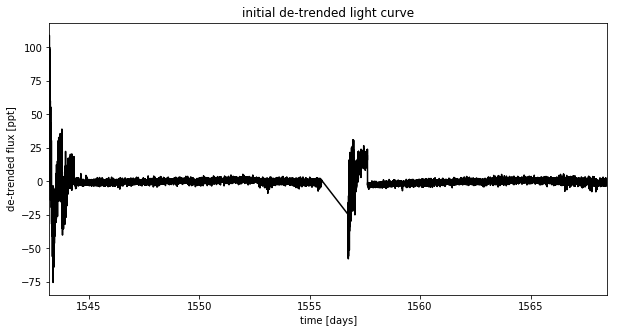

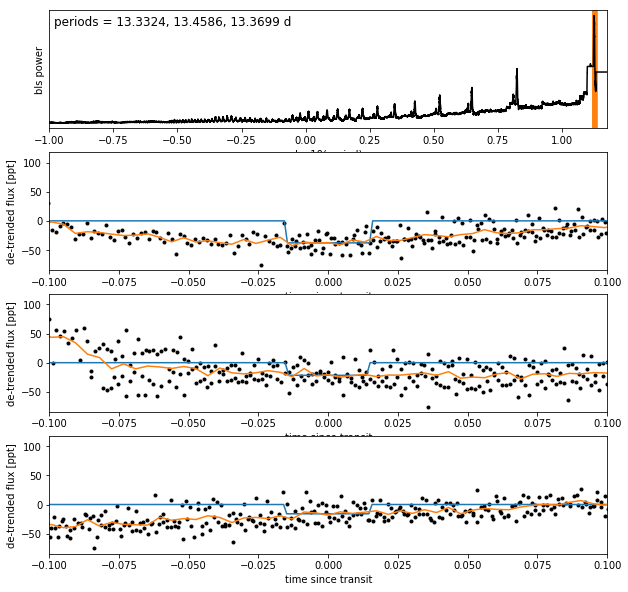

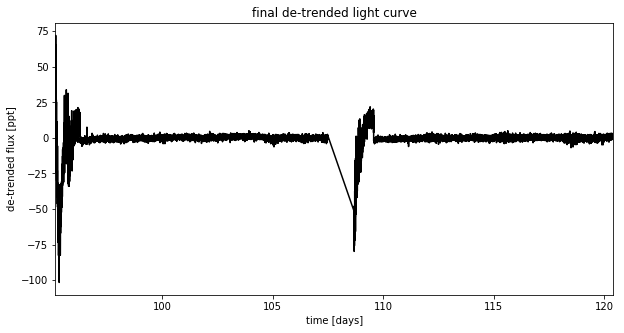

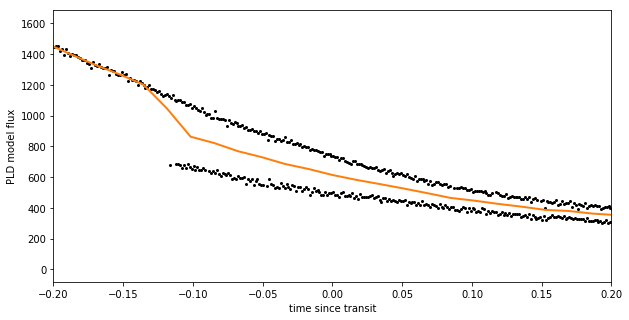

In [9]:
xs = []
ys = []
for tpf in tpf_all:
    pix_mask = tpf.create_threshold_mask(threshold=3)
    flux = tpf.flux
    
    lc = tpf.extract_aperture_photometry(aperture_mask=pix_mask, )
    lc = lc.normalize()
    lc.flux = (lc.flux - 1.0) * 1e3
    # Build the first order PLD basis
    X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
    X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

    # Build the second order PLD basis and run PCA to reduce the number of dimensions
    X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
    U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
    X2_pld = U[:, :X_pld.shape[1]]

    # Construct the design matrix and fit for the PLD model
    X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
    XTX = np.dot(X_pld.T, X_pld)
    w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, lc.flux))
    pld_flux = np.dot(X_pld, w_pld)

    # Plot the de-trended light curve
    plt.figure(figsize=(10, 5))
    plt.plot(lc.time, lc.flux-pld_flux, "k")
    plt.xlabel("time [days]")
    plt.ylabel("de-trended flux [ppt]")
    plt.title("initial de-trended light curve")
    plt.xlim(lc.time.min(), lc.time.max());
    
    period_grid = np.exp(np.linspace(np.log(0.1), np.log(15), 50000))
    duration = 0.03

    bls_periods = np.zeros([3])
    bls_t0s = np.zeros([3])
    bls_depths = np.zeros([3])
    time = lc.time - ref_time

    # planet 1
    bls = BoxLeastSquares(time, lc.flux - pld_flux)
    bls_power = bls.power(period_grid, duration, oversample=20)

    bls_power0 = bls_power

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    bls_period = bls_power.period[index]
    bls_t0 = bls_power.transit_time[index]
    bls_depth = bls_power.depth[index]
    transit_mask = bls.transit_mask(time, bls_period, 3*duration, bls_t0)

    bls_periods[0] = bls_period
    bls_t0s[0] = bls_t0
    bls_depths[0] = bls_depth

    # planet 2
    bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
    bls_power = bls.power(period_grid, duration, oversample=20)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    bls_period = bls_power.period[index]
    bls_t0 = bls_power.transit_time[index]
    bls_depth = bls_power.depth[index]
    transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

    bls_periods[1] = bls_period
    bls_t0s[1] = bls_t0
    bls_depths[1] = bls_depth

    # planet 3
    bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
    bls_power = bls.power(period_grid, duration, oversample=20)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    bls_period = bls_power.period[index]
    bls_t0 = bls_power.transit_time[index]
    bls_depth = bls_power.depth[index]
    transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

    bls_periods[2] = bls_period
    bls_t0s[2] = bls_t0
    bls_depths[2] = bls_depth
    
    fig, axes = plt.subplots(4, 1, figsize=(10, 10))

    # Plot the periodogram
    ax = axes[0]
    ax.axvline(np.log10(bls_periods[0]), color="C1", lw=5, alpha=0.8)
    ax.axvline(np.log10(bls_periods[1]), color="C1", lw=5, alpha=0.8)
    ax.axvline(np.log10(bls_periods[2]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_power0.period), bls_power0.power, "k")
    ax.annotate("periods = {0:.4f}, {1:.4f}, {2:.4f} d".format(*bls_periods),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    ax.set_xlabel("log10(period)")

    # Plot the folded transits
    bls = BoxLeastSquares(time, lc.flux - pld_flux)
    for i in range(3):
        ax = axes[i+1]
        x_fold = (time - bls_t0s[i] + 0.5*bls_periods[i])%bls_periods[i] - 0.5*bls_periods[i]
        m = np.abs(x_fold) < 0.4
        ax.plot(x_fold[m], lc.flux[m] - pld_flux[m], ".k")
        inds = np.argsort(x_fold[m])
        ax.plot(x_fold[m][inds], bls.model(time, bls_periods[i], duration, bls_t0s[i])[m][inds])

        # Overplot the phase binned light curve
        bins = np.linspace(-0.11, 0.11, 52)
        denom, _ = np.histogram(x_fold, bins)
        num, _ = np.histogram(x_fold, bins, weights=lc.flux - pld_flux)
        denom[num == 0] = 1.0
        ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

        ax.set_xlim(-0.1, 0.1)
        ax.set_ylabel("de-trended flux [ppt]")
        ax.set_xlabel("time since transit");
        
    m = ~transit_mask
    XTX = np.dot(X_pld[m].T, X_pld[m])
    w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, lc.flux[m]))
    pld_flux = np.dot(X_pld, w_pld)

    x = np.ascontiguousarray(lc.time-ref_time, dtype=np.float64)
    y = np.ascontiguousarray(lc.flux-pld_flux, dtype=np.float64)

    plt.figure(figsize=(10, 5))
    plt.plot(x, y, "k")
    plt.xlabel("time [days]")
    plt.ylabel("de-trended flux [ppt]")
    plt.title("final de-trended light curve")
    plt.xlim(x.min(), x.max());
    
    plt.figure(figsize=(10, 5))

    x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
    m = np.abs(x_fold) < 0.3
    plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

    bins = np.linspace(-0.5, 0.5, 60)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=pld_flux)
    denom[num == 0] = 1.0
    plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
    plt.xlim(-0.2, 0.2)
    plt.xlabel("time since transit")
    plt.ylabel("PLD model flux");
    
    xs.append(x)
    ys.append(y)
    
 

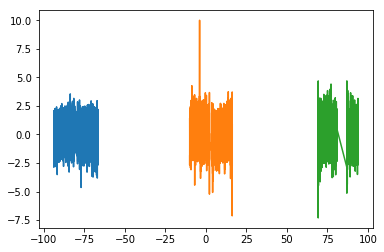

In [10]:
for i in range(3):
    plt.plot(xs[i], ys[i])

In [11]:
1362.7375 - ref_time, 

(-85.31728818939905,)

In [13]:
def build_model(masks=None, start=None):
    bls_periods = [2.2529, 3.69018, 7.4508]
    bls_t0s = [-81.8839881893989, -80.77968818939894, -85.31728818939905]
    bls_depths = [0.6, 1.8, 1.8]
    if masks is None:
        masks = []
        for x in xs:
            mask = np.ones(len(x), dtype=bool)
            masks.append(mask)
    with pm.Model() as model:
        
        # constant parameters among all data sets
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        R_star_kostov = 0.312, 0.015
        Rho_star_kostov = 15
        r_star = pm.Normal("r_star", mu=R_star_kostov[0], sd=R_star_kostov[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star_kostov), sd=0.2)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        pm.Potential("rho_star_prior", tt.switch(rho_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(bls_periods), sd=0.2, shape=3)
        t0 = pm.Normal("t0", mu=bls_t0s, sd=0.2, shape=3)
        logror = pm.Normal("logror", mu=np.log(np.sqrt(1e-3)*np.sqrt(bls_depths)),
                           sd=2, shape=3)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=3)
        b = pm.Deterministic("b", b_param * (1 + ror))
        ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.03, 0.02, 0.04], shape=3)
        omega = xo.distributions.Angle("omega", shape=3)
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.005 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))
        
        
        
        period = pm.Deterministic("period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", (r_star * ror / 0.009155))
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            rho_star=rho_star,
            )
        a = pm.Deterministic("a", orbit.a)
#         inc = pm.Deterministic("inc", orbit.inc)
        
        
        ####
        # Parameters for the stellar properties
        
        mean_0 = pm.Normal("mean_0".format(i), mu=0.0, sd=10.0)
        mean_1 = pm.Normal("mean_1".format(i), mu=0.0, sd=10.0)
        mean_2 = pm.Normal("mean_2".format(i), mu=0.0, sd=10.0)
           
        # Transit jitter & GP parameters
        logs2_0 = pm.Normal("logs2_0", mu=np.log(np.var(ys[0][masks[0]])), sd=10)
        logs2_1 = pm.Normal("logs2_1", mu=np.log(np.var(ys[1][masks[1]])), sd=10)
        logs2_2 = pm.Normal("logs2_2", mu=np.log(np.var(ys[2][masks[2]])), sd=10)
        
        logS0_0 = pm.Normal("logS0_0", mu=np.log(np.var(ys[0][masks[0]])), sd=10)
        logS0_1 = pm.Normal("logS0_1", mu=np.log(np.var(ys[1][masks[1]])), sd=10)
        logS0_2 = pm.Normal("logS0_2", mu=np.log(np.var(ys[2][masks[2]])), sd=10)
        
        logw0_0 = pm.Normal("logw0_0", mu=np.log(2*np.pi/10), sd=10)
        logw0_1 = pm.Normal("logw0_1", mu=np.log(2*np.pi/10), sd=10)
        logw0_2 = pm.Normal("logw0_2", mu=np.log(2*np.pi/10), sd=10)


        # Compute the model light curve using starry
        light_curves_0 = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=xs[0][masks[0]], texp=texp)*1e3
        light_curves_1 = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=xs[1][masks[1]], texp=texp)*1e3
        light_curves_2 = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=xs[2][masks[2]], texp=texp)*1e3
        
        light_curve_0 = pm.math.sum(light_curves_0, axis=-1)
        light_curve_1 = pm.math.sum(light_curves_1, axis=-1)
        light_curve_2 = pm.math.sum(light_curves_2, axis=-1)
        
        pm.Deterministic("light_curve_0", light_curve_0)
        pm.Deterministic("light_curve_1", light_curve_1)
        pm.Deterministic("light_curve_2", light_curve_2)
        
        model.light_curves_0 = light_curves_0
        model.light_curves_1 = light_curves_1
        model.light_curves_2 = light_curves_2

        # GP model for the light curve
        kernel_0 = xo.gp.terms.SHOTerm(log_S0=logS0_0, log_w0=logw0_0, Q=1/np.sqrt(2))
        kernel_1 = xo.gp.terms.SHOTerm(log_S0=logS0_1, log_w0=logw0_1, Q=1/np.sqrt(2))
        kernel_2 = xo.gp.terms.SHOTerm(log_S0=logS0_2, log_w0=logw0_2, Q=1/np.sqrt(2))
        
        gp_0 = xo.gp.GP(kernel_0, xs[0][masks[0]], tt.exp(logs2_0) + tt.zeros(masks[0].sum()), J=2)
        gp_1 = xo.gp.GP(kernel_1, xs[1][masks[1]], tt.exp(logs2_1) + tt.zeros(masks[1].sum()), J=2)
        gp_2 = xo.gp.GP(kernel_2, xs[2][masks[2]], tt.exp(logs2_2) + tt.zeros(masks[2].sum()), J=2)
        
        pm.Potential("transit_obs_0", gp_0.log_likelihood(ys[0][masks[0]] - light_curve_0 - mean_0))
        pm.Potential("transit_obs_1", gp_1.log_likelihood(ys[1][masks[1]] - light_curve_1 - mean_1))
        pm.Potential("transit_obs_2", gp_2.log_likelihood(ys[2][masks[2]] - light_curve_2 - mean_2))
        
        pm.Deterministic("gp_pred_0", gp_0.predict())
        pm.Deterministic("gp_pred_1", gp_1.predict())
        pm.Deterministic("gp_pred_2", gp_2.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2_0, logs2_1, logs2_2,
                                                  logS0_0, logS0_1, logS0_2,
                                                  logw0_0, logw0_1, logw0_2])
#         map_soln = pm.find_MAP(start=map_soln, vars=[model.rb])
        map_soln = xo.optimize(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['logw0_2', 'logw0_1', 'logw0_0', 'logS0_2', 'logS0_1', 'logS0_0', 'logs2_2', 'logs2_1', 'logs2_0']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -63895.74731575728 -> -63740.783560569194
optimizing logp for variables: ['b_param_interval__', 'logror']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Desired error not necessarily achieved due to precision loss.
logp: -63740.783560569194 -> -63324.39073018702
optimizing logp for variables: ['logw0_2', 'logw0_1', 'logw0_0', 'logS0_2', 'logS0_1', 'logS0_0', 'logs2_2', 'logs2_1', 'logs2_0', 'mean_2', 'mean_1', 'mean_0', 'omega_angle__', 'ecc_logodds__', 'b_param_interval__', 'logror', 't0', 'logP', 'logrho_star', 'r_star', 'u_star_quadlimbdark__']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Desired error not necessarily achieved due to precision loss.
logp: -63324.390730187035 -> -62777.52486905753


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


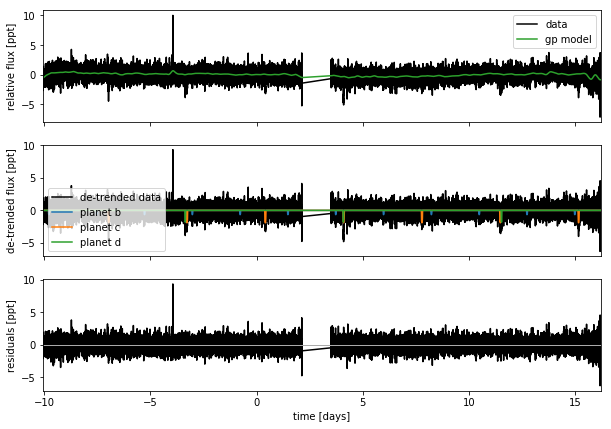

In [14]:
# def plot_light_curve(model, soln, mask=None):
#     if mask is None:
#         mask = np.ones(len(x), dtype=bool)

#     fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

#     ax = axes[0]
#     ax.plot(x[mask], y[mask], "k", label="data")
#     gp_mod = xo.utils.eval_in_model(model.gp_pred, soln, model=model)
#     gp_mod += soln["mean"]
#     ax.plot(x[mask], gp_mod, color="C2", label="gp model")
#     ax.legend(fontsize=10)
#     ax.set_ylabel("relative flux [ppt]")

#     ax = axes[1]
#     ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
#     light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
#     for i, l in enumerate(["b", "c", 'd']):
#         mod = light_curves[:, i]
#         ax.plot(x[mask], mod, label="planet {0}".format(l))
#     ax.legend(fontsize=10, loc=3)
#     ax.set_ylabel("de-trended flux [ppt]")

#     ax = axes[2]
#     mod = gp_mod + np.sum(light_curves, axis=-1)
#     ax.plot(x[mask], y[mask] - mod, "k")
#     ax.axhline(0, color="#aaaaaa", lw=1)
#     ax.set_ylabel("residuals [ppt]")
#     ax.set_xlim(x[mask].min(), x[mask].max())
#     ax.set_xlabel("time [days]")
    
#     return fig

def plot_light_curve(model, soln, mask=None):
    
    x = xs[1]
    y = ys[1]
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    else:
        mask = mask[1]

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.gp_pred_1, soln, model=model)
    gp_mod += soln["mean_0"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves_1, soln, model=model)
    for i, l in enumerate(["b", "c", 'd']):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    

fig = plot_light_curve(model0, map_soln0)


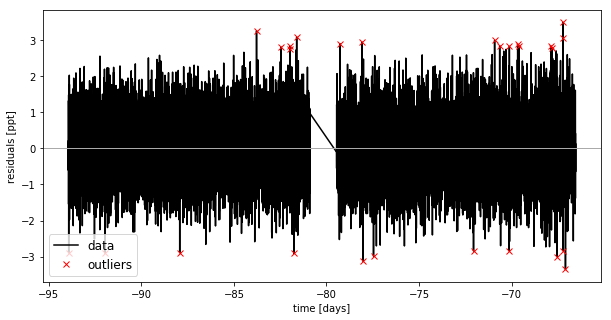

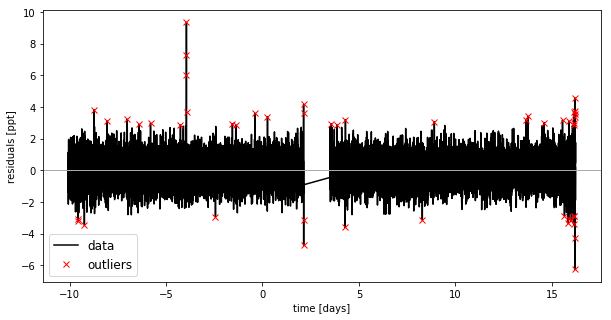

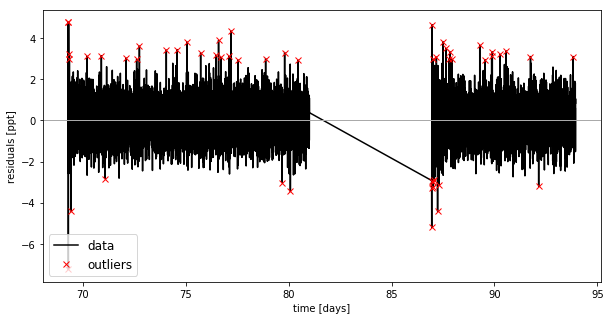

In [15]:
masks = []
for i in range(3):
    mod = map_soln0["gp_pred_{}".format(i)] + map_soln0["mean_{}".format(i)] + map_soln0["light_curve_{}".format(i)]
    resid = ys[i] - mod
    rms = np.sqrt(np.median(resid**2))
    mask = np.abs(resid) < 5 * rms
    masks.append(mask)

    plt.figure(figsize=(10, 5))
    plt.plot(xs[i], resid, "k", label="data")
    plt.plot(xs[i][~mask], resid[~mask], "xr", label="outliers")
    plt.axhline(0, color="#aaaaaa", lw=1)
    plt.ylabel("residuals [ppt]")
    plt.xlabel("time [days]")
    plt.legend(fontsize=12, loc=3)
#     plt.xlim(x.min(), x.max());

optimizing logp for variables: ['logw0_2', 'logw0_1', 'logw0_0', 'logS0_2', 'logS0_1', 'logS0_0', 'logs2_2', 'logs2_1', 'logs2_0']
message: Optimization terminated successfully.
logp: -61586.2826192735 -> -61559.000058380465
optimizing logp for variables: ['b_param_interval__', 'logror']
message: Optimization terminated successfully.
logp: -61559.00005838047 -> -61558.99310384634
optimizing logp for variables: ['logw0_2', 'logw0_1', 'logw0_0', 'logS0_2', 'logS0_1', 'logS0_0', 'logs2_2', 'logs2_1', 'logs2_0', 'mean_2', 'mean_1', 'mean_0', 'omega_angle__', 'ecc_logodds__', 'b_param_interval__', 'logror', 't0', 'logP', 'logrho_star', 'r_star', 'u_star_quadlimbdark__']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Desired error not necessarily achieved due to precision loss.
logp: -61558.993103846355 -> -61558.94587117769


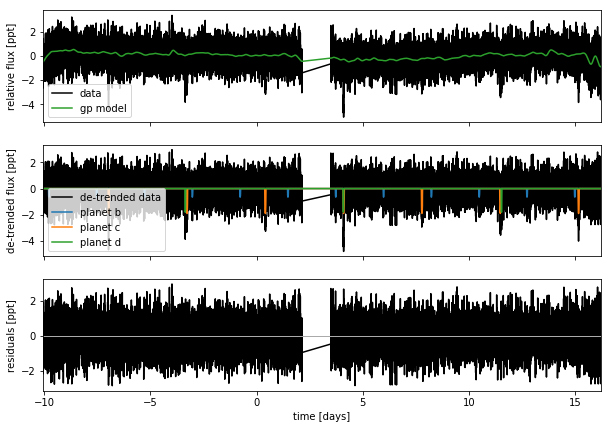

In [16]:
model, map_soln = build_model(masks, map_soln0)
plot_light_curve(model, map_soln, masks);

In [17]:
sampler = xo.PyMC3Sampler(finish=2000)
with model:
    burnin = sampler.tune(tune=6000, start=map_soln, step_kwargs=dict(target_accept=0.9))

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 8008/8008 [2:23:54<00:00,  3.53s/draws]  


In [18]:
with model:
#     db = pm.backends.Text('l98-trace')
    trace = sampler.sample(draws=5000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logw0_2, logw0_1, logw0_0, logS0_2, logS0_1, logS0_0, logs2_2, logs2_1, logs2_0, mean_2, mean_1, mean_0, omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star]
Sampling 4 chains: 100%|██████████| 20000/20000 [5:40:54<00:00,  1.26s/draws]  
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [19]:
pm.summary(trace, varnames= ['b_param', 'logror', 't0', 'logP', 'ecc', 'omega','rho_star',
           'logrho_star', 'r_star', 'u_star',  
                             'logw0_0', 'logS0_0',
                             'logs2_0', 'mean_0', 
                             'logw0_1', 'logS0_1',
                             'logs2_1', 'mean_1', 
                             'r_ple', 'period'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b_param__0,0.349788,0.183496,2.245846e-03,8.153663e-04,0.643131,6866.861881,1.000384
b_param__1,0.281958,0.166411,2.346875e-03,2.931161e-05,0.568645,5686.743318,1.000662
b_param__2,0.802797,0.146514,2.774397e-03,4.774815e-01,0.963167,3007.864922,1.000959
logror__0,-3.754007,0.038571,3.486192e-04,-3.827022e+00,-3.675886,11416.872211,0.999998
logror__1,-3.225712,0.025246,3.538604e-04,-3.272986e+00,-3.174429,5572.253282,1.000657
logror__2,-3.065019,0.154145,9.391905e-03,-3.263494e+00,-2.935894,247.182514,1.016533
t0__0,-81.884731,0.000667,4.825636e-06,-8.188611e+01,-81.883451,20939.387026,0.999910
t0__1,-80.779250,0.000341,2.395537e-06,-8.077993e+01,-80.778584,20692.838980,0.999949
t0__2,-85.316939,0.000648,7.439962e-06,-8.531817e+01,-85.315639,10908.935945,1.000250
logP__0,0.812326,0.000008,5.655158e-08,8.123108e-01,0.812341,19756.225547,1.000030


In [20]:
# Compute the GP prediction
gp_mod = np.median(trace["pred_0"] , axis=0)

pletter = ['b', 'c', 'd']
fig,  axes = plt.subplots(3,1, figsize=[8, 8])
for i, pnum in enumerate([2,0,1]):
    ax1 = axes[i]
    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:,pnum])
    t0 = np.median(trace['t0'][:,pnum])

    # Plot the folded data

    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    ax1.plot(x_fold * 24., y[mask] - gp_mod, ".k", label="data",
             alpha=0.5, zorder=-1000, mec="none")

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = np.add(trace['mean'], trace["light_curve"][:, inds].T ).T
    pred = np.percentile(pred, [5, 50, 95], axis=0)
    ax1.plot(x_fold[inds] * 24., pred[1], color="C1", label="model")
    art = ax1.fill_between(x_fold[inds] * 24., pred[0], pred[2], color="C1", alpha=0.3,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
#     txt = "period = {0:.5f} +/- {1:.5f} days".format(
#         np.mean(trace["period"][:,pnum]), np.std(trace["period"][:,pnum]))

#     ax1.annotate(txt, (0, 0.8), xycoords="axes fraction",
#                  xytext=(5, 5), textcoords="offset points",
#                  ha="left", va="bottom", fontsize=12)
#     txt = "radius = {0:.2f} +/- {1:.2f} $R_\oplus$".format(
#         np.mean(trace["r_ple"][:,pnum]), np.std(trace["r_ple"][:,pnum]))
#     ax1.annotate(txt, (0.6, 0.8), xycoords="axes fraction",
#                  xytext=(5, 5), textcoords="offset points",
#                  ha="left", va="bottom", fontsize=12)
    ax1.annotate('L98-59 ' + pletter[i], (0., 0.8), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12, weight='bold')


    ax1.legend(fontsize=10, loc=4)
    ax1.set_xlabel("time since transit [hours]")
    ax1.set_ylabel("de-trended flux (ppt)")
    ax1.set_xlim(-3, 3);
    ax1.set_ylim(-3, 3);

plt.tight_layout()

KeyError: 'Unknown variable pred'

In [22]:
pm.save_trace(trace)

'.pymc_5.trace'